<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Questions
* what does detrending data do? 
    * find out how correlated data is with previous data
        * is it correlated with the previous day, 2 days, 3 days? etc
    * detrend to find the number of coefficients we need for modeling 
* train/test splits
    * ex: 6 years of data 
    * train set - first 5 years 
    * test set - last year 
* how to avoid overfitting
    * detrended data to train 
    * deep learning - autoencoders to predict anomally

In [1]:
filepath = "../dsc-corr-autocorr-in-time-series-online-ds-ft-120919/google_trends.csv"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(filepath, skiprows=1)
df.head()

,Month,diet: (Worldwide),gym: (Worldwide),finance: (Worldwide)
0,2004-01,100,31,47
1,2004-02,77,27,49
2,2004-03,75,25,47
3,2004-04,73,24,47
4,2004-05,75,23,44


In [4]:
col_names = ["_".join(col.lower().replace(" ", "").replace("(", "").replace(")", "").split(":")) for col in df.columns]
col_names

['month', 'diet_worldwide', 'gym_worldwide', 'finance_worldwide']

In [5]:
col_mapper = dict(zip(df.columns, col_names))
col_mapper

{'Month': 'month',
 'diet: (Worldwide)': 'diet_worldwide',
 'gym: (Worldwide)': 'gym_worldwide',
 'finance: (Worldwide)': 'finance_worldwide'}

In [6]:
df.rename(mapper=col_mapper, axis=1, inplace=True)
df.head()

,month,diet_worldwide,gym_worldwide,finance_worldwide
0,2004-01,100,31,47
1,2004-02,77,27,49
2,2004-03,75,25,47
3,2004-04,73,24,47
4,2004-05,75,23,44


# What we learned? 
* what zip does
* terminal issues are common
* detrending data and why to use it
* using a mapper to rename columns

In [7]:
df_diet = df[['month', 'diet_worldwide']]
df_diet

,month,diet_worldwide
0,2004-01,100
1,2004-02,77
2,2004-03,75
3,2004-04,73
4,2004-05,75
...,...,...
174,2018-07,55
175,2018-08,52
176,2018-09,48
177,2018-10,45


In [8]:
df_diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   month           179 non-null    object
 1   diet_worldwide  179 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


In [9]:
df_diet['month'] = pd.to_datetime(df_diet['month'])
df_diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   month           179 non-null    datetime64[ns]
 1   diet_worldwide  179 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.9 KB


In [10]:
df_diet.set_index('month', inplace=True)
df_diet.head()

,diet_worldwide
month,
2004-01-01,100
2004-02-01,77
2004-03-01,75
2004-04-01,73
2004-05-01,75


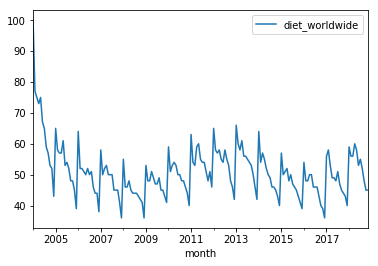

In [11]:
df_diet.plot()
plt.show()

# let's try and do a train/test split on some model in sktime

In [12]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss

In [13]:
# y = load_airline()
# y_train, y_test = temporal_train_test_split(y)
y = df_diet.copy()
y = y['2011':]
y_train, y_test = temporal_train_test_split(y, test_size=0.25)

display(y_train.head())
display(y_train.tail())

display(y_test.head())

,diet_worldwide
month,
2011-01-01,63
2011-02-01,54
2011-03-01,53
2011-04-01,59
2011-05-01,60


,diet_worldwide
month,
2016-07-01,46
2016-08-01,46
2016-09-01,43
2016-10-01,40
2016-11-01,39


,diet_worldwide
month,
2016-12-01,36
2017-01-01,56
2017-02-01,58
2017-03-01,53
2017-04-01,49


In [14]:
fh = np.arange(1, len(y_test) + 1)  # forecasting horizon 1 - length of test size
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [15]:
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train.reset_index()['diet_worldwide'])

ThetaForecaster(sp=12)

In [16]:
y_preds = forecaster.predict(fh)
type(y_preds)

pandas.core.series.Series

In [17]:
y_test['preds'] = y_preds.values
y_test.head()

,diet_worldwide,preds
month,,
2016-12-01,36,36.172667
2017-01-01,56,52.903181
2017-02-01,58,46.702254
2017-03-01,53,46.957964
2017-04-01,49,47.871894


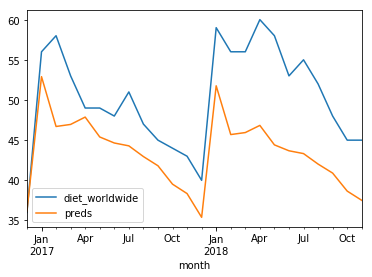

In [18]:
y_test.plot()
plt.show()

# why the poor fit?
* could be train/test split sucked
* could be the test data is distinctly different
* 

In [19]:
import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss

In [20]:
# y = load_airline()
# y_train, y_test = temporal_train_test_split(y)
# fh = np.arange(1, len(y_test) + 1)  # forecasting horizon
regressor = RandomForestRegressor()
forecaster = ReducedRegressionForecaster(regressor, window_length=12)
forecaster.fit(y_train.reset_index()['diet_worldwide'])

RecursiveRegressionForecaster(regressor=RandomForestRegressor(),
                              window_length=12)

In [21]:
y_pred_freg = forecaster.predict(fh)
y_test['y_pred_freg'] = y_pred_freg.values
y_test.head()

,diet_worldwide,preds,y_pred_freg
month,,,
2016-12-01,36,36.172667,39.98
2017-01-01,56,52.903181,50.65
2017-02-01,58,46.702254,47.91
2017-03-01,53,46.957964,48.48
2017-04-01,49,47.871894,49.09


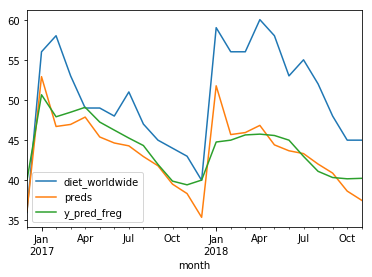

In [22]:
y_test.plot()
plt.show()

In [23]:
from sktime.regression import TimeSeriesForestRegressor

# what did we learn today? 
* sktime - how to use it
* how to test/train split time series data
* check vertical distance for error
* learned how to feed in train data for sktime 
    * reindex on integers starting with 1 (I'm assuming)

In [24]:
from sktime.forecasting.arima import AutoARIMA

In [25]:
arima = AutoARIMA()

ModuleNotFoundError: No module named 'pmdarima'